In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

import findspark
findspark.init()

In [3]:
from pyspark import SparkContext

sc = SparkContext(master="local", appName="final")

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pyspark.sql.functions as F
from pyspark.sql.types import IntegerType
from pyspark.sql import SQLContext
from pyspark.sql.types import StructType, StringType, ArrayType, StructField,DoubleType

In [8]:
from pyspark.sql import SparkSession
spark = SparkSession(sc)

In [31]:
# Tạo RDD từ dữ liệu 
rdd = spark.sparkContext.textFile("mnist_small_test.csv")

# Chuyển RDD thành DataFrame
df = rdd.map(lambda line: line.split(",")).toDF()

# Đặt tên cho các cột
df = df.withColumnRenamed("_1", "label")
df = df.selectExpr("cast(label as int) as label", *["cast(_{0} as int) as pixel_{0}".format(i) for i in range(2, 786)])

In [10]:
# Hàm chuyển đổi vector ảnh thành ma trận
def reshape_image(row):
    pixels = row[1:]
    return (row[0], [pixels[i:i+28] for i in range(0, len(pixels), 28)])

# Áp dụng hàm chuyển đổi vào DataFrame
df = df.rdd.map(reshape_image).toDF(["label", "image"])

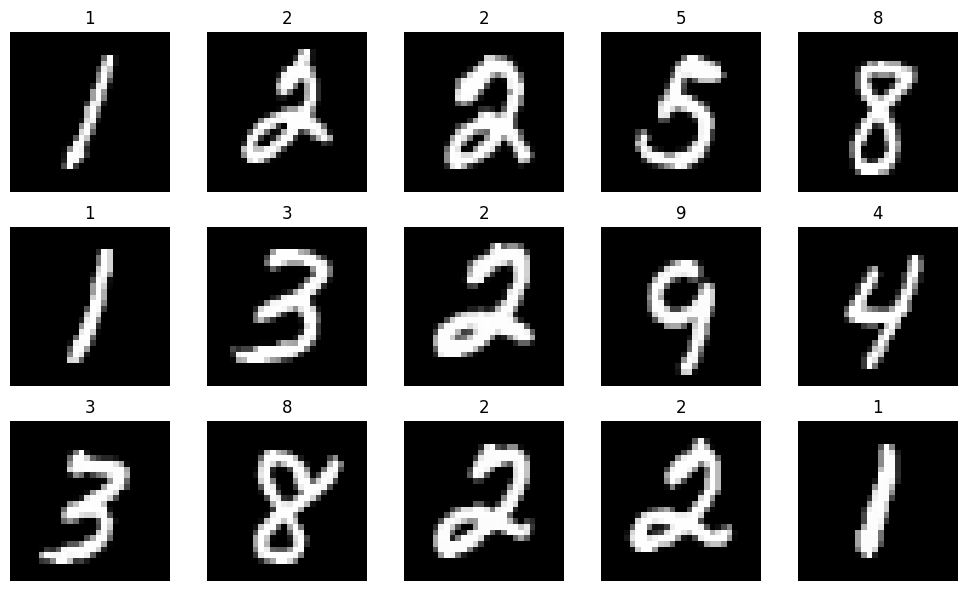

In [13]:
# Lấy 15 bức ảnh đầu tiên
sample_df = df.limit(15).toPandas()

# Tạo lưới 3 x 5 và hiển thị ảnh
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(10, 6))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(sample_df["image"][i], cmap="gray")
    ax.set_title(str(sample_df["label"][i]))
    ax.axis("off")

plt.tight_layout()
plt.show()

In [52]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeansModel
from pyspark.sql.functions import udf

In [38]:
# Lựa chọn các cột pixel để tạo DataFrame chứa dữ liệu đầu vào cho KMeans
feature_cols = ["pixel_{}".format(i) for i in range(2,786)]

# Tạo VectorAssembler để tạo cột "features" từ các cột pixel
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Tạo DataFrame chỉ chứa các cột pixel
input_data = df.select(*feature_cols)

# Biến đổi DataFrame để thêm cột "features"
input_data = assembler.transform(input_data)

In [54]:
# Chọn giá trị k
k_values = [5, 10, 15]

# Tạo mô hình và tính toán tổng khoảng cách Euclidean cho mỗi giá trị k
models = []
distances = []

for k in k_values:
    # Tạo mô hình KMeans với giá trị k
    kmeans = KMeans().setK(k).setSeed(42)

    # Huấn luyện mô hình
    model = kmeans.fit(input_data)

    # Phân cụm dữ liệu
    predictions = model.transform(input_data)

    # Lưu mô hình xuống file
    model.write().overwrite().save("kmeans_model_k{}".format(k))
    
    # Load mô hình từ file
    loaded_model = KMeansModel.load("kmeans_model_k{}".format(k))

    # Đánh giá mô hình
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    
    # Tính tổng khoảng cách Euclidean từ mỗi điểm dữ liệu tới centroid tương ứng
    evaluator = ClusteringEvaluator()
    distance = evaluator.evaluate(loaded_model.transform(input_data))
    distances.append(distance)
    
    models.append(loaded_model)

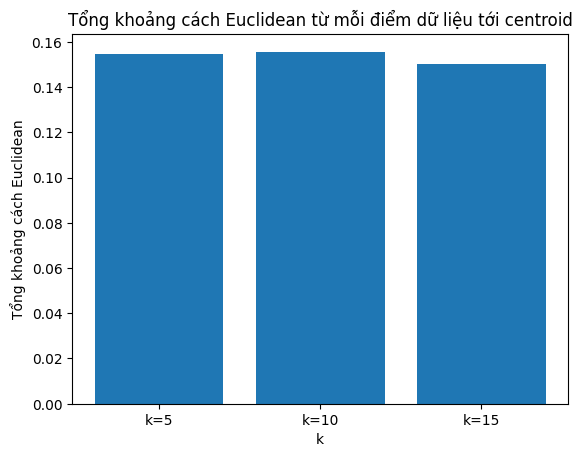

In [59]:
# Chia cột x thành các nhóm
x_ticks = np.arange(len(k_values))
group_labels = ['k={}'.format(k) for k in k_values]

# Vẽ biểu đồ cột
plt.bar(x_ticks, distances, tick_label=group_labels)
plt.xlabel('k')
plt.ylabel('Tổng khoảng cách Euclidean')
plt.title('Tổng khoảng cách Euclidean từ mỗi điểm dữ liệu tới centroid')
plt.show()